# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
import scipy.stats as stats
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

cuda


In [2]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [22]:
def poly_rot_autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    tdir_arr = tcom_arr-pol_com
    tdir_arr /= torch.norm(tdir_arr, dim=1)[:,None,:]

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tdir_arr, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)

In [4]:
def autocorr_dist_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):

    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_auto_corr_list = []
        std_auto_corr_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            auto_corr_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                valid_n = int((-ss_ind+end_ind)/2)
                lag_arr = h5_data['time'][:valid_n]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                avg_dist = cps.avg_dist_from_poly_com(com_arr)
                n_beads = com_arr.shape[0]
                auto_corr_list += [cps.poly_dist_autocorr_fast(com_arr)[:valid_n]-(avg_dist.mean()**2)]
            min_length = min([len(avg) for avg in auto_corr_list])
            auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
            
            avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
            std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(lag_arr[:min_length], 
                                (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),
                                color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Autocorrelation ($\mu$m$^2$)\n' + r'$C_r - \langle |\Delta R_i| \rangle^2$')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_yscale('log')
        # _ = ax.set_ylim(0.0001)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
        pass

In [16]:
def power_spec_dist_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_power_spec_list = []
        std_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue
            # TODO Go through and check to see if one of the seeds didn't finish.
            #      If so, make that the new end_ind if it is less than the end_ind 
            #      given.

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                dt = time_arr[2]-time_arr[1]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]
                power_spec, freqs  = cps.poly_dist_power_spec(com_arr,dt)
                power_spec_list += [power_spec]
            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
            std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(freqs, 
                                (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                                color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Real dist power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        # _ = ax.set_ylim(0.0001)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
        pass

In [18]:
def power_spec_ang_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_power_spec_list = []
        std_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue
            # TODO Go through and check to see if one of the seeds didn't finish.
            #      If so, make that the new end_ind if it is less than the end_ind 
            #      given.

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                dt = time_arr[2]-time_arr[1]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]
                power_spec, freqs  = cps.poly_rot_power_spec(com_arr,dt)
                power_spec_list += [power_spec]
            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(dim=0).cpu()]
            std_power_spec_list += [power_spec_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(freqs, avg_power_spec_list[-1].real, color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_power_spec_list[-1].real/np.sqrt(len(avg_power_spec_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(freqs, 
                                (avg_power_spec_list[-1].real - ci), (avg_power_spec_list[-1].real + ci),
                                color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Real ang power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = ax.set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        # _ = ax.set_ylim(0.0001)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
        pass

In [19]:
def power_spec_graph_func(fig, axarr, data_path, param_str, label_str,
                        ss_ind=1,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None):
    try:
        axarr[0,0].sharey(axarr[0,1])
        axarr[0,0].sharex(axarr[0,1])
        axarr[1,0].sharex(axarr[1,1])
        axarr[1,0].sharey(axarr[1,1])

        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        # Make color scale
        log_pvs = np.log10(param_vals)
        norm_log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(norm_log_pvs)

        avg_power_spec_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            power_spec_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][:-ss_ind+end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                power_spec = cps.power_spec(com_arr, device)
                n_ps_pos_vals = int(power_spec.size(dim=0)/2)
                freq = torch.fft.fftfreq(power_spec.size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

                _ = axarr[0, 0].plot(freq, power_spec.real.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)
                _ = axarr[1, 0].plot(freq, power_spec.imag.cpu()[:n_ps_pos_vals], color=colors[i], alpha=.1)

                power_spec_list += [power_spec[:n_ps_pos_vals]]

            power_spec_mat = torch.stack([avg for avg in power_spec_list])
            
            avg_power_spec_list += [power_spec_mat.mean(axis=0)]
            # std_auto_corr_list += [power_spec_mat.std(axis=0)]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
            
            # Make sure you get the right scale of the frequency array
            #   Nyquist frequency should be 1/(2 * \Delta t)
            # n_ps_pos_vals = int(avg_power_spec_list[-1][:min_length].size(dim=0)/2)
            # freq_arr = torch.fft.fftfreq(avg_power_spec_list[-1][:min_length].size(dim=0), time_arr[2]-time_arr[1])[:n_ps_pos_vals]

            _ = axarr[0, 1].plot(freq, avg_power_spec_list[-1].real.to('cpu'), 
                                 color=colors[i], label=f"{label_str}$= {label}$")
            _ = axarr[1, 1].plot(freq, avg_power_spec_list[-1].imag.to('cpu'), 
                                 color=colors[i], label=f"$ k_o = {label}$")
        
        _ = axarr[0,0].set_ylabel('Real power spectrum \n' + r'Re$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = axarr[1,0].set_ylabel('Imaginary power spectrum \n' + r'Im$[\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle]$')
        _ = axarr[0,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
        _ = axarr[0,0].set_yscale('log')
        _ = axarr[0,0].set_xscale('log')
        _ = axarr[1,0].set_yscale('log')
        _ = axarr[1,0].set_xscale('log')

        _ = axarr[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [23]:
def autocorr_ang_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):

    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)
        avg_auto_corr_list = []
        std_auto_corr_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            auto_corr_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                valid_n = int((-ss_ind+end_ind)/2)
                lag_arr = h5_data['time'][:valid_n]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]
                auto_corr_list += [poly_rot_autocorr_fast(com_arr)[:valid_n]]
            min_length = min([len(avg) for avg in auto_corr_list])
            auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
            
            avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
            std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Angular autocorrelation \n' + 
                          r'$C_a=\langle \hat{R}(t+\tau)\cdot\hat{R}(t)\rangle$')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_yscale('log')
        _ = ax.set_ylim(0.01)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()

# Data

In [10]:
data_dir_list = {
cond_path /"22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations", 
cond_path /"22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations", 
cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations", 
cond_path /"22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations", 
cond_path /"22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations", 
cond_path /"22-12-08_aLchr1_scan7.12_Ke30_kod3.05_line800_2xLs.01-.07/simulations", 
}

running_dir_list = {
cond_path /"22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations"
}

# Figures

## Ke scans

0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

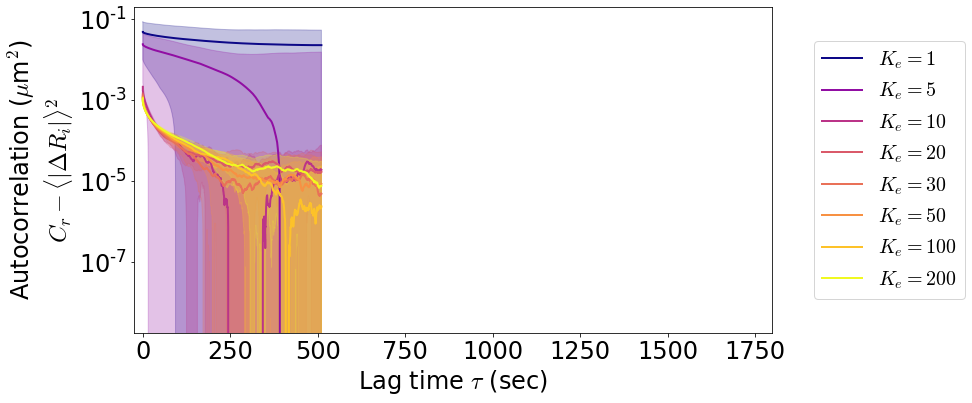

In [18]:
data_path = (ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
autocorr_dist_graph_func_ci(fig, ax, data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

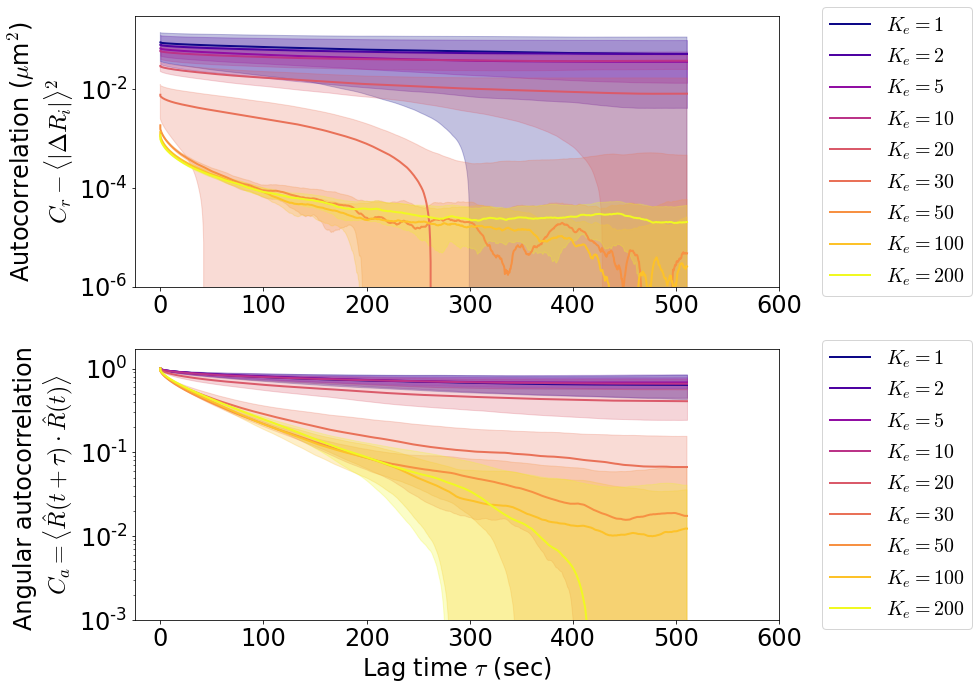

In [15]:
data_path = (
    ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations")
fig, axarr = plt.subplots(2,1, figsize=(14, 10))
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, 
                            "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 600)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 600)
_ = axarr[1].set_ylim(.1**3)
fig.tight_layout()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

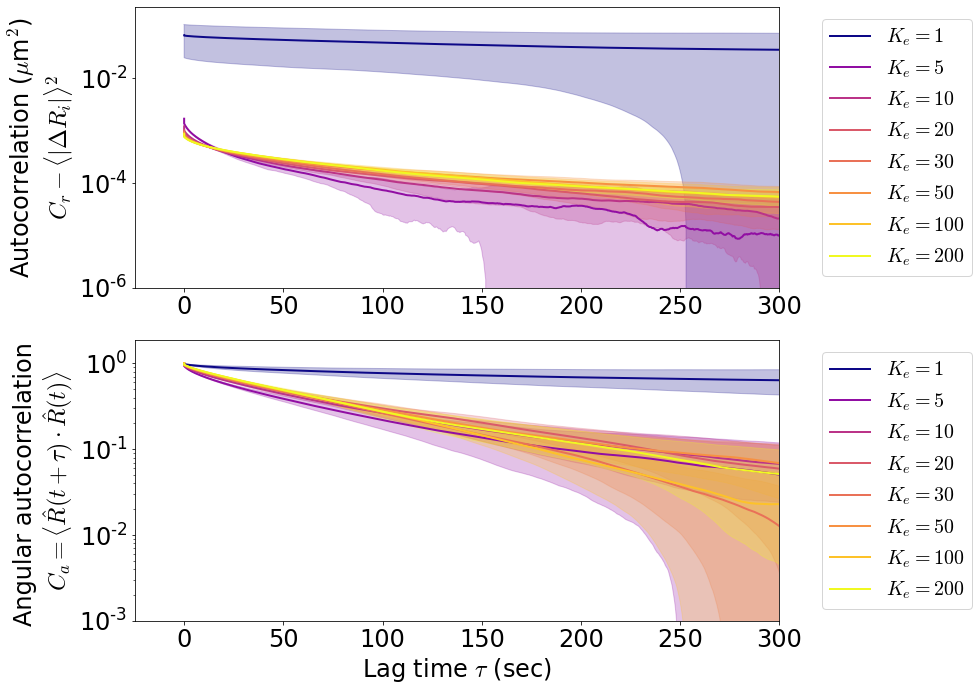

In [17]:
data_path = (cond_path /"22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations")
fig, axarr = plt.subplots(2,1, figsize=(14, 10))
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, 
                            "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 300)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 300)
_ = axarr[1].set_ylim(.1**3)
fig.tight_layout()

## $\ell_s$ scans

0it [00:00, ?it/s]

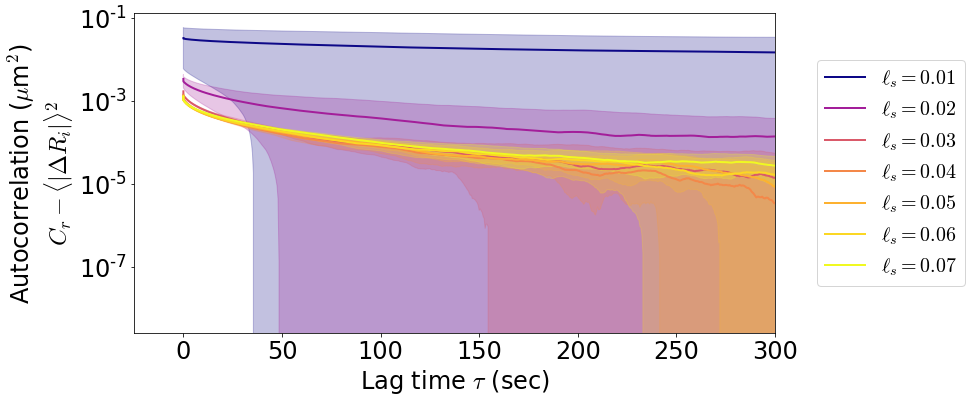

In [10]:
data_path = (ceph_path / "CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
autocorr_dist_graph_func_ci(fig, ax, data_path, "Ls", "$\ell_s$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 300)

0it [00:00, ?it/s]

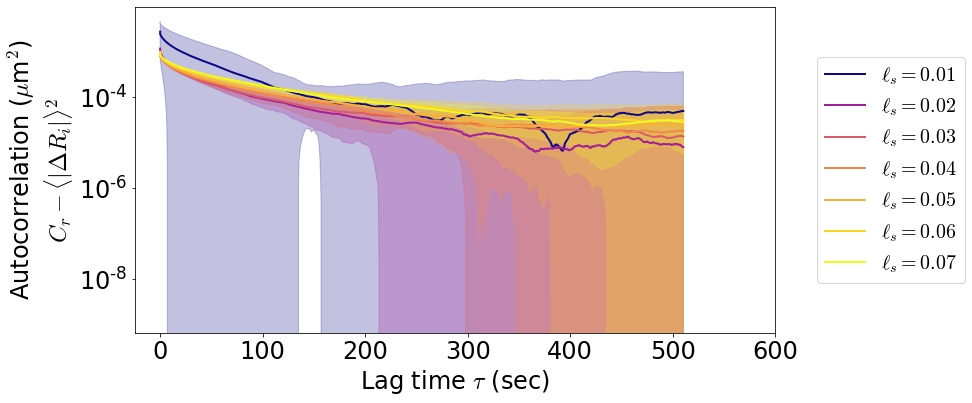

In [23]:
data_path = (ceph_path / "CondCharPaper/22-12-08_aLchr1_scan7.12_line800_Ke30_kod3.05_2xLs.01-.07/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
autocorr_dist_graph_func_ci(fig, ax, data_path, "Ls", "$\ell_s$",
                    ci_bound = .95,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 600)

## $k_o$ scans

0it [00:00, ?it/s]

0it [00:00, ?it/s]

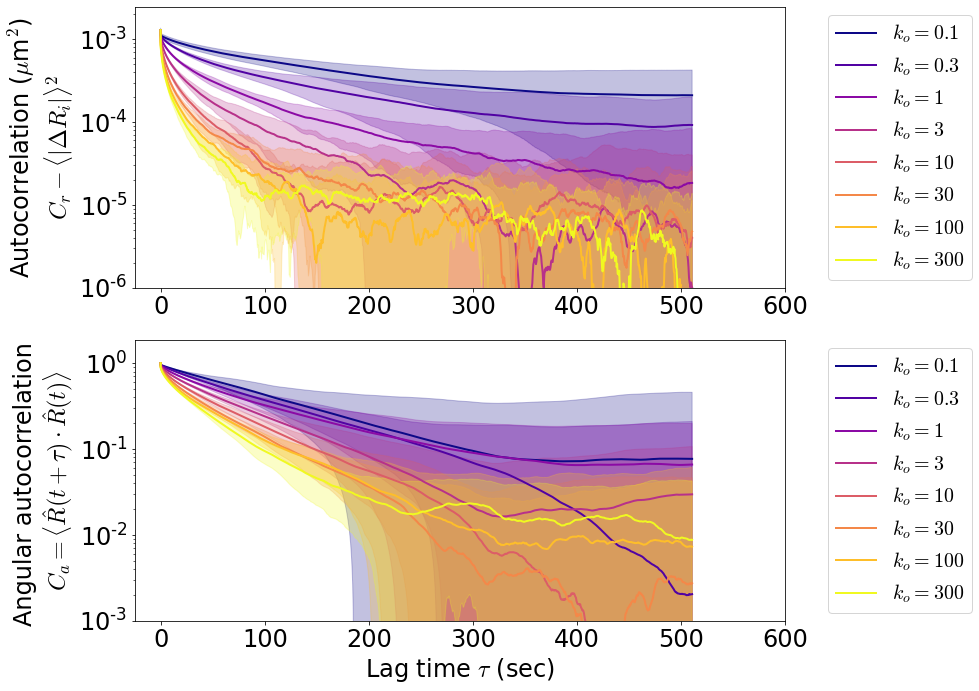

In [ ]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
fig, axarr = plt.subplots(2,1, figsize=(10, 10))
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 600)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 600)
_ = axarr[1].set_ylim(.1**3)
fig.tight_layout()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

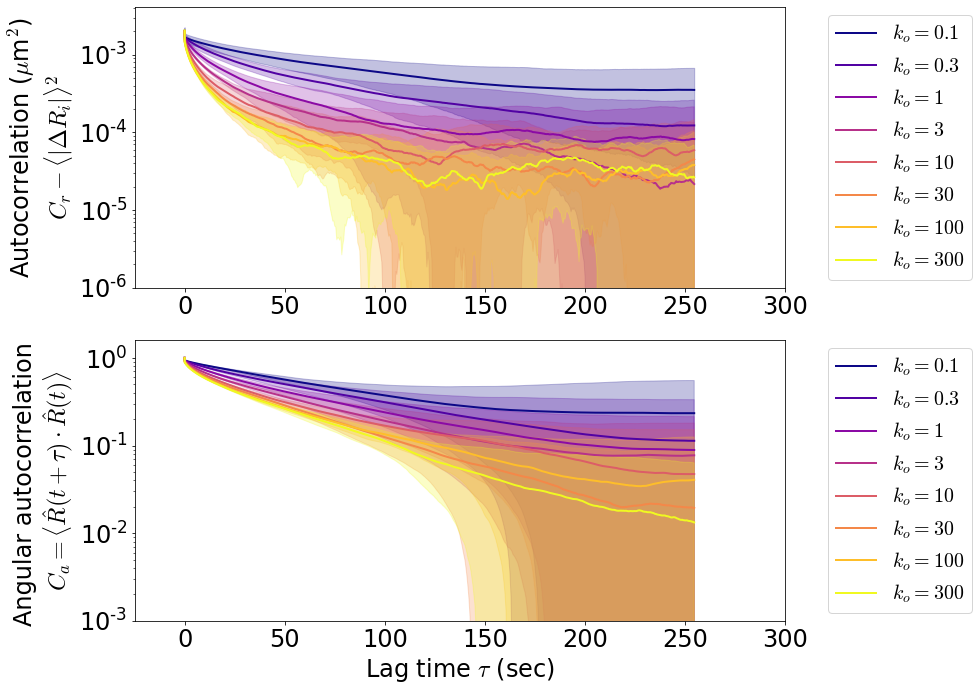

In [ ]:
data_path = ( cond_path / "22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations") 
fig, axarr = plt.subplots(2,1, figsize=(10, 10))
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-1023,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 300)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-1023,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 300)
_ = axarr[1].set_ylim(.1**3)
fig.tight_layout()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

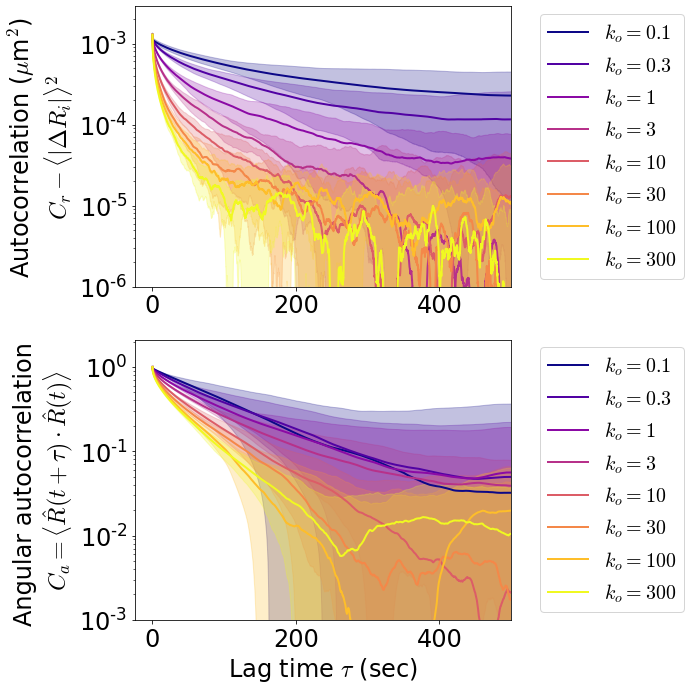

In [25]:
data_path = (ceph_path /"CondCharPaper/23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations")

fig, axarr = plt.subplots(2,1, figsize=(10, 10))
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 500)
_ = axarr[1].set_ylim(.1**3)
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 500)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
fig.tight_layout()